In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [3]:
path = 'MovieSummaries/'

character=pd.read_csv(path+'character.metadata.tsv',sep='\t',header=None, names=['wiki_movie_ID','Freebase_movie_ID','release_date','character_name','actor_birth','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age','character_actor_map_ID','Freebase_character_ID','Freebase_actor_ID'])
cmu_movies = pd.read_csv(path+'movie.metadata.tsv',sep='\t',header=None,names=['wiki_movie_ID','Freebase_movie_ID','movie_name','date','revenue','runtime','languages','countries','genres'])
name = pd.read_csv(path+'name.clusters.txt',sep='\t',header=None,names=['name','character_actor_map_ID'])
plot_summary = pd.read_csv(path+'plot_summaries.txt',sep='\t',header=None,names=['wiki_movie_ID','summary'])
tv_tropes = pd.read_csv(path+'tvtropes.clusters.txt',sep='\t',header=None,names=['name','character_actor_map'])
imdb_movies = pd.read_csv(path+'imdb_title.tsv',sep='\t')
ratings = pd.read_csv(path+'rating.tsv',sep='\t')


/Users/silviaromanato/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#df= pd.read_csv(r"C:\Users\41782\OneDrive\Desktop\complementary data.csv", index_col='id')

In [4]:
display(character.head())
display(cmu_movies.head())
display(name.head())
display(plot_summary.head())
display(tv_tropes.head())
display(imdb_movies.head())
display(ratings.head())

,wiki_movie_ID,Freebase_movie_ID,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


,wiki_movie_ID,Freebase_movie_ID,movie_name,date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


,name,character_actor_map_ID
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


,wiki_movie_ID,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


,name,character_actor_map
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


,tconst,averageRating,numVotes
0,tt0000001,5.7,1922
1,tt0000002,5.8,259
2,tt0000003,6.5,1734
3,tt0000004,5.6,174
4,tt0000005,6.2,2546


In [5]:
# print(len(np.where(imdb_movies.startYear.isnull())[0]))
# print(len(np.where(cmu_movies.date.isnull())[0]))

In [8]:
#   UNIQUE MOVIE NAMES
print(len(cmu_movies.movie_name.unique()))
print(len(imdb_movies.originalTitle.unique()))

75478
4306431


In [5]:
cmu_movies['month_day'] = cmu_movies['date'].apply(lambda x: x[5:] if len(str(x))>3 else np.nan)
cmu_movies['year'] = cmu_movies['date'].apply(lambda x: x[0:4] if len(str(x))>3 else x)
cmu_movies=cmu_movies.drop('date', axis = 1)

In [8]:
# df['year'] = df['release_date'].apply(lambda x: str(x)[-4:] if len(str(x))>0 else np.nan)
# df=df.drop('release_date', axis = 1)

In [6]:
### Merge movies from IMDB and from CMU Movie Summary Corpus
movies = cmu_movies.merge(imdb_movies,left_on=['movie_name', 'year', 'language'],right_on=['primaryTitle', 'startYear'], how="inner")
print(movies.shape)
#display(movies.head())

(61079, 19)


In [201]:
movies_with_ratings= movies.merge(ratings, left_on='tconst', right_on='tconst', how='inner')
print(movies_with_ratings.shape)

(50834, 21)


In [11]:
#bdf = cmu_movies.merge(df,left_on=['movie_name', 'year'],right_on=['title', 'year'], how="inner")

#bdf: movies data with budget


In [12]:
#print(bdf.shape)

In [12]:
#print(len(np.where(bdf.budget==0)[0]))

In [202]:
movies_with_ratings.head()

,wiki_movie_ID,Freebase_movie_ID,movie_name,revenue,runtime,languages,countries,genres_x,month_day,year,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_y,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",08-24,2001,...,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi",4.9,55254
1,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",08-24,2001,...,tvEpisode,Ghosts of Mars,Ghosts of Mars,0,2001,\N,\N,"Documentary,Short",7.9,19
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",,1988,...,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama",5.7,40
3,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",,1983,...,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama,6.0,590
4,13696889,/m/03cfc81,The Gangsters,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",05-29,1913,...,short,The Gangsters,The Gangsters,0,1913,\N,35,"Comedy,Short",6.8,16


In [203]:
movies_with_ratings = movies_with_ratings.drop('genres_y', axis = 1)
movies_with_ratings = movies_with_ratings.rename(columns = {'genres_x':'genres'})

In [204]:
movies_with_ratings['languages'] = movies_with_ratings['languages'].apply(lambda x: x.split('"')[3] if len(x)>3 else np.nan)
movies_with_ratings['countries'] = movies_with_ratings['countries'].apply(lambda x: x.split('"')[3] if len(x)>3 else np.nan)
movies_with_ratings['genres'] = movies_with_ratings['genres'].apply(lambda x: list(json.loads(x).values()))

In [205]:
movies_with_ratings['sumRatings']= movies_with_ratings['averageRating']*movies_with_ratings['numVotes']
movies_with_ratings = movies_with_ratings.drop('Freebase_movie_ID', axis = 1)
#movies_with_ratings = movies_with_ratings.drop('tconst', axis = 1)
movies_with_ratings = movies_with_ratings.drop('primaryTitle', axis = 1)
movies_with_ratings = movies_with_ratings.drop('originalTitle', axis = 1)

In [206]:
print('The percentage of null values for the feautre endYear is', np.array(movies_with_ratings.endYear == '\\N').sum()/movies_with_ratings.shape[0])

The percentage of null values for the feautre endYear is 0.993390250619664


In [207]:
movies_with_ratings = movies_with_ratings.drop('endYear', axis = 1)

In [209]:
#movies_with_ratings[movies_with_ratings['runtimeMinutes'] == '\\N']['runtimeMinutes'] = np.nan
#movies_with_ratings[movies_with_ratings['runtimeMinutes'].notna()]['runtimeMinutes']
#print('The missing values of runtimeMinutes with respect to runtime',(np.array(movies_with_ratings['runtimeMinutes'], dtype = 'float64') == np.array(movies_with_ratings['runtime'], dtype = 'float64')).sum())

In [210]:
movies_with_ratings = movies_with_ratings.drop('runtimeMinutes', axis = 1)

We will now compare thhe year and the start year

In [211]:
movies_with_ratings['year'] = np.array(movies_with_ratings['year'],dtype='int')
movies_with_ratings['startYear'] = np.array(movies_with_ratings['startYear'],dtype='int')
(movies_with_ratings['year'] == movies_with_ratings['startYear']).sum()/movies_with_ratings.shape[0]

1.0

Since they are identical we drop the startYear column:

In [212]:
movies_with_ratings = movies_with_ratings.drop('startYear', axis = 1)

I will drop the movies with less than 20 number of votes in order to proceed with my evaluation of the movies according to their ratings:

In [213]:
movies_with_ratings = movies_with_ratings[movies_with_ratings['numVotes']> 20]

Drop rows with 0 runtime:

In [227]:
movies_with_ratings = movies_with_ratings.drop(np.where(movies_with_ratings['runtime'] == 0)[0], axis = 0)

In [230]:
movies_with_ratings.head()

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes,sumRatings
0,975900,Ghosts of Mars,14010832.0,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",08-24,2001,tt0228333,movie,0,4.9,55254,270744.6
2,28463795,Brun bitter,NaN,83.0,Norwegian Language,Norway,"[Crime Fiction, Drama]",,1988,tt0094806,movie,0,5.7,40,228.0
3,261236,A Woman in Flames,NaN,106.0,German Language,Germany,[Drama],,1983,tt0083949,movie,0,6.0,590,3540.0
5,10408933,Alexander's Ragtime Band,3600000.0,106.0,English Language,United States of America,"[Musical, Comedy, Black-and-white]",08-16,1938,tt0029852,movie,0,6.9,2159,14897.1
6,175026,Sarah and Son,NaN,86.0,English Language,United States of America,"[Drama, Black-and-white]",,1930,tt0021335,movie,0,5.4,272,1468.8


We will now check for non unicity of the movies in the dataset:

In [232]:
movies_with_ratings.loc[movies_with_ratings.duplicated(subset=['wiki_movie_ID'], keep = False)]

,wiki_movie_ID,movie_name,revenue,runtime,languages,countries,genres,month_day,year,tconst,titleType,isAdult,averageRating,numVotes,sumRatings
76,7707787,Carmen,NaN,119.0,French Language,Spain,"[Romantic drama, Romance Film, Drama, World ci...",10-03,2003,tt0352230,movie,0,6.1,2176,13273.6
77,7707787,Carmen,NaN,119.0,French Language,Spain,"[Romantic drama, Romance Film, Drama, World ci...",10-03,2003,tt0372361,movie,0,6.2,162,1004.4
85,7460227,The Bridge,NaN,69.0,English Language,United States of America,[Drama],09-01,2006,tt0799954,movie,0,7.2,11719,84376.8
86,4953051,The Bridge,NaN,94.0,English Language,United States of America,[Documentary],,2006,tt0799954,movie,0,7.2,11719,84376.8
87,7460227,The Bridge,NaN,69.0,English Language,United States of America,[Drama],09-01,2006,tt0907842,movie,0,7.6,171,1299.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50763,2472440,Turbulence,11538235.0,101.0,English Language,United States of America,"[Thriller, Disaster, Action, Action/Adventure]",01-10,1997,tt0120390,movie,0,4.9,11927,58442.3
50764,2472440,Turbulence,11538235.0,101.0,English Language,United States of America,"[Thriller, Disaster, Action, Action/Adventure]",01-10,1997,tt0168104,video,0,6.2,23,142.6
50787,30748966,Haunted,NaN,143.0,Hindi Language,India,"[Thriller, Mystery, Horror]",05-06,2011,tt1864767,tvEpisode,0,6.9,96,662.4
50788,30748966,Haunted,NaN,143.0,Hindi Language,India,"[Thriller, Mystery, Horror]",05-06,2011,tt1876871,tvEpisode,0,8.5,1209,10276.5


In [234]:
#plot of top 20 countries for ratings
languages_20 = pd.DataFrame(movies_with_ratings.groupby('languages')[['averageRating', 'numVotes', 'sumRatings']].mean().sort_values('averageRating', ascending=False))[0:20]
languages_20.head()

,averageRating,numVotes,sumRatings
languages,,,
Rajasthani language,9.100,21.0,191.100
Hariyani,8.800,56.0,492.800
"Khmer, Central Language",8.200,294.0,2410.800
Hmong language,8.100,774319.0,6271983.900
Assamese Language,8.075,60.5,502.325


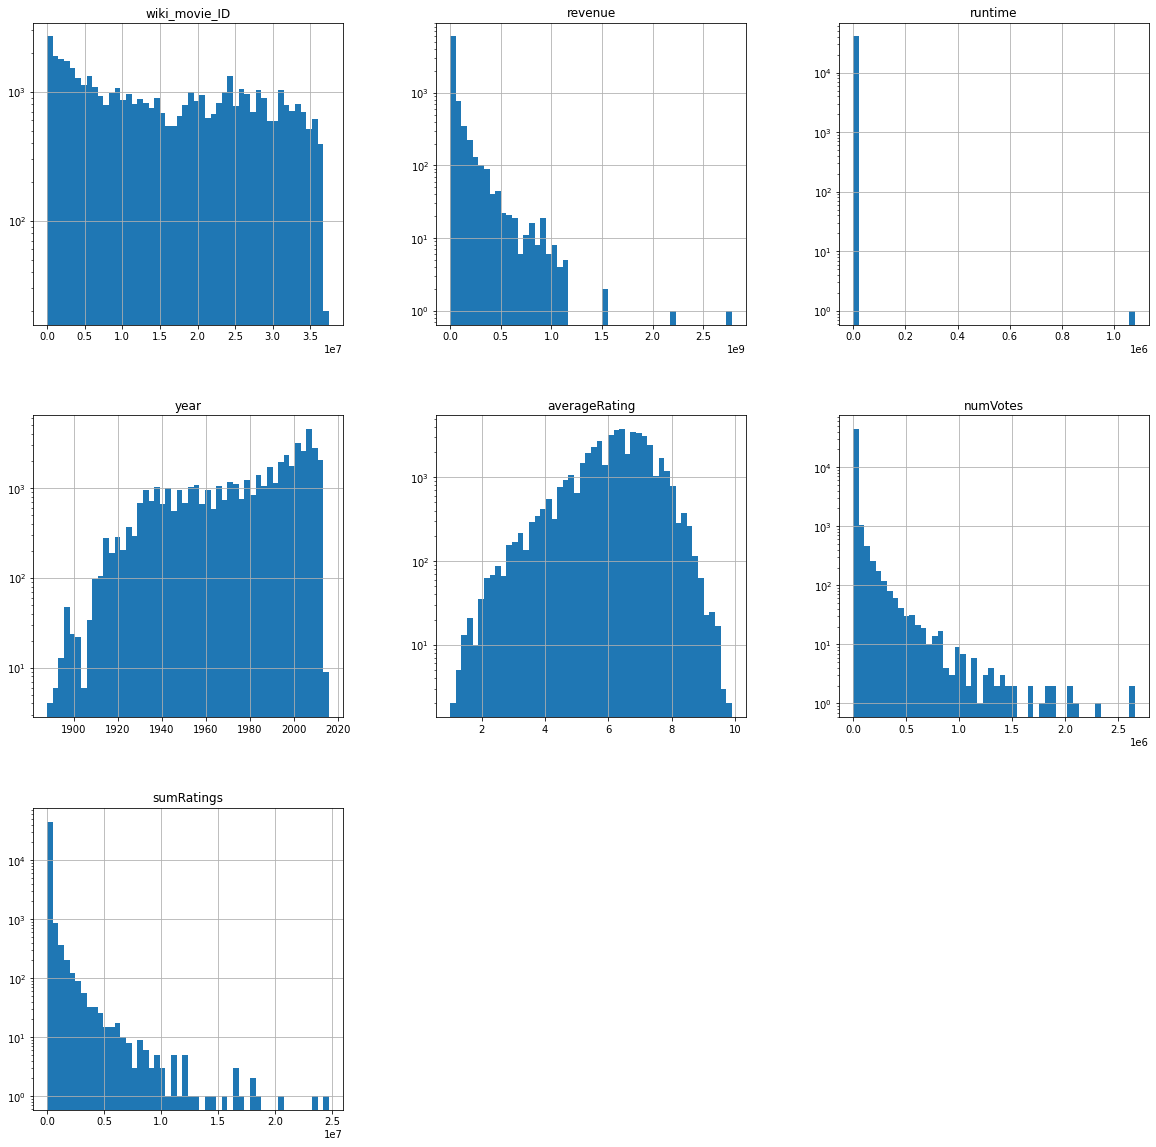

In [235]:
#to be. changed not finished yet
movies_with_ratings.hist(bins=50, figsize=(20,20), log = True)
plt.show()

(array([3.8182e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.25000000e+00, 1.07929225e+05, 2.15857200e+05, 3.23785175e+05,
        4.31713150e+05, 5.39641125e+05, 6.47569100e+05, 7.55497075e+05,
        8.63425050e+05, 9.71353025e+05, 1.07928100e+06]),
 <BarContainer object of 10 artists>)

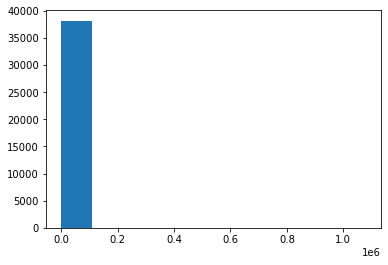

In [214]:
#plt.hist(movies_with_ratings[movies_with_ratings.titleType != 'short']['runtime'])

In [114]:
#from collections import Counter
#a = ['a', 'a', 'a', 'a', 'b', 'b', 'c', 'c', 'c', 'd', 'e', 'e', 'e', 'e', 'e']
#letter_counts = Counter(a)
#df = pandas.DataFrame.from_dict(letter_counts, orient='index')
#df.plot(kind='bar')

<function <lambda> at 0x7fe201d0f830>
